# Dynamic Time Warping

<!--bibtex
@book{Mueller15_FundamentalsMusicProcessig_SPRINGER,
author    = {Meinard M\"{u}ller},
title     = {Fundamentals of Music Processing -- Audio, Analysis, Algorithms, Applications},
type      = {Monograph},
year      = {2015},
isbn      = {978-3-319-21944-8},
publisher = {Springer Verlag}
}
-->

This notebook is supposed to explain dynamic time warping to align two sequences.
We consider an example from the book [](#cite-Mueller15_FundamentalsMusicProcessig_SPRINGER)

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time

Define input sequences $X = (x_1, x_2, \ldots, x_N)$ and $Y = (y_1, y_2, \ldots, y_M)$.

In [2]:
X = np.array([[1], [3], [3], [8], [1]])
Y = np.array([[2], [0], [0], [8], [7], [2]])

$\Sigma$ describes the possible step sizes.

In [3]:
step_sizes_sigma = np.array([[1, 1], [0, 1], [1, 0]])
# step_sizes_sigma = np.array([[1, 1], [1, 2], [2, 1]])
step_weights = np.array([1, 1, 1])

## Cost Matrix $C$

Calculate the cost matrix $C \in \mathbb{R}^{N \times M}$ by a pairwise comparison of the elements of $X$ and $Y
with respect to a given cost function. For this example we use the euclidean distance of the elements.

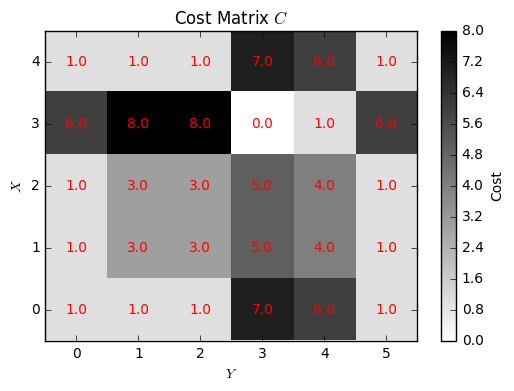

In [4]:
from scipy.spatial.distance import cdist
C = cdist(X, Y, 'euclidean')
plt.imshow(C, cmap=plt.get_cmap('gray_r'),
           origin='lower', interpolation='nearest', aspect='auto')
plt.ylabel('$X$')
plt.xlabel('$Y$')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cost')
plt.title('Cost Matrix $C$')

# add numbers to the plot
for x in range(C.shape[0]):
    for y in range(C.shape[1]):
        plt.annotate(str(C[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center', color='red')

## Accumulated Cost Matrix $D$

### Initialization

The accumulated cost matrix $D \in \mathbb{R}^{N \times M}$ is initialized as described in the book.
We use the trick of infinity-value rows and columns to make life easier.

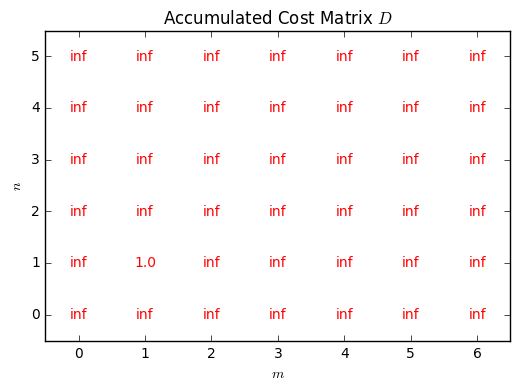

In [5]:
max_0 = step_sizes_sigma.max(axis=0).max()
max_1 = step_sizes_sigma.max(axis=1).max()

# initalize whole matrix with infinity values
D = np.ones(C.shape + np.array([max_0, max_1])) * np.inf

# set starting point to C[0, 0]
D[max_0, max_1] = C[0, 0]
    
plt.imshow(D, cmap=plt.get_cmap('gray_r'),
           origin='lower', interpolation='nearest', aspect='auto')
plt.ylabel('$n$')
plt.xlabel('$m$')
plt.title('Accumulated Cost Matrix $D$')

# add numbers to the plot
for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        plt.annotate(str(D[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center', color='red')

### Iteration

Now, we iterate over $D$ to fill the remaining elements.

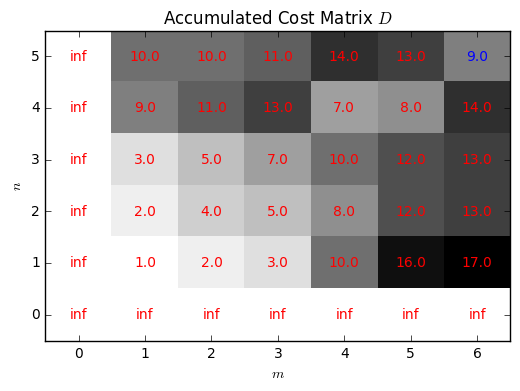

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
plt.ylabel('$n$')
plt.xlabel('$m$')
ax.set_title('Accumulated Cost Matrix $D$')

# add numbers numbers to the plot
annotations = []
for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        plt.annotate(str(D[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center', color='red')

for n in np.arange(max_0, D.shape[0]):
    for m in np.arange(max_1, D.shape[1]):
        # loop over possible step sizes
        for cur_weight_idx, cur_step_size in enumerate(step_sizes_sigma):
            cur_cost = D[n-cur_step_size[0], m-cur_step_size[1]]
            cur_cost += step_weights[cur_weight_idx] * C[n-max_0, m-max_1]

            D[n, m] = np.min(np.array([cur_cost, D[n, m]]))
        
        imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                         origin='lower', interpolation='nearest', aspect='auto')
    
        # redraw annotations numbers to the plot
        del ax.texts[:]
        
        for x in range(D.shape[0]):
            for y in range(D.shape[1]):
                if (x == n and y == m):
                    cur_color = 'blue'
                else:
                    cur_color = 'red'

                plt.annotate(str(D[x][y]), xy=(y, x), 
                             horizontalalignment='center',
                             verticalalignment='center', color=cur_color)

        display.display(plt.gcf())
        display.clear_output(wait=True)
        # time.sleep(0.5)

## Warping Path $p$

To retrieve a warping path $p \in (p_1, \ldots, p_L)$ with
$p_l = (n_l, m_l) \in [1:N] \times [1:M]$ for $l \in [1:L]$,
we perform a backtracking through $D$.

In [7]:
p = []

# Set starting point D(N,M) and append it to path
cur_idx = (D.shape[0]-1, D.shape[1]-1)
p.append(cur_idx)

while True:
    n = cur_idx[0]
    m = cur_idx[1]
    
    # look up neighborhood
    cur_idxs = []
    cur_minima = []
    for cur_step_size in step_sizes_sigma:
        n_next = n-cur_step_size[0]
        m_next = m-cur_step_size[1]
        cur_minima.append(D[n_next, m_next])
        cur_idxs.append((n_next, m_next))

    # save tuple with minimal acc. cost in path
    cur_idx = cur_idxs[np.argmin(cur_minima)]
    p.append(cur_idx)

    if cur_idx == (max_0, max_1):
        break

# reverse path
p = p[::-1]

### Visualization

First, we need to delete the inifinity value rows and columns and modify the warping path accordingly.

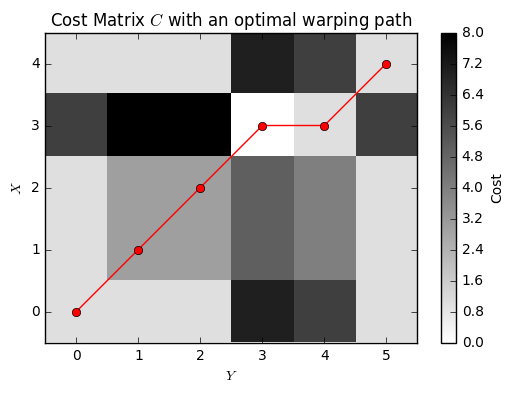

In [8]:
D_adj = D[max_0:, max_1:]
p_adj = [(cur_item[0]-max_0, cur_item[1]-max_1) for cur_item in p]

fig = plt.figure()
ax = fig.add_subplot(111)
imax = ax.imshow(C, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')

x_val = [x[1] for x in p_adj]
y_val = [x[0] for x in p_adj]
ax.plot(x_val, y_val, marker='o', color='r')
ax.autoscale(tight=True)
plt.ylabel('$X$')
plt.xlabel('$Y$')
cbar = fig.colorbar(imax)
cbar.ax.set_ylabel('Cost')
ax.set_title('Cost Matrix $C$ with an optimal warping path')